# **AP157 Machine Learning Lab Assignment**
## Module A.2: Classification -- Morphological Classification of Galaxies using Decision Trees

_Instructions_: Answer each part of the assignment as completely as you can. Discuss **all** your code and results as clearly and concisely as possible.

_Scoring Criteria_: 50% - *correctness of code*; 50% - *discussion of the code and results*. Maximum score is **100 points** (Parts 1, 2, and 3 are worth 20, 40, and 40 points, respectively).

_Credits_: This assignment is based on the Week 6 module of the Coursera course "Data-driven Astronomy", "Exploring machine learning classification" ([link](https://www.coursera.org/learn/data-driven-astronomy/home/welcome))

### Student Information

_Full Name (Last Name, First Name)_: Paul Kenneth H. Remo \
_Student No._:2020-01185\
_Section_:TX1

### Submission Information

_Date and Time Submitted (most recent upload)_:3:25PM

**HONOR PLEDGE** I affirm that I have upheld the highest principles of honesty and integrity in my academic work and that this lab assignment is my own work.

**Sign here with your full name:PAUL KENNETH H. REMO**

### Grading Information (c/o Instructor)

TOTAL SCORE: **[]**/100

Score breakdown:
* Part 1 - []/20
* Part 2 - []/40
* Part 3 - []/40

_Date and Time Scored (MM/DD/YYYY HH:MM AM/PM):_

For this assignment, you will work with galaxy data from the
Sloan Digital Sky Survey (SDSS). First, you need to make a copy of the binary file ```galaxy_catalogue.npy``` and save it to a folder in your **own Google Drive**. This file is available from the AP157 Machine Learning Google Drive (under the Datasets folder).

The code cells below will (1) mount your Google Drive and (2) load ```galaxy_catalogue.npy``` from your Google Drive folder.

Mount the Google Drive where you saved the .npy file.

When you run this cell, you will be asked to sign in to your Google account and you will get an authorization code. Paste the code on the provided cell to mount the Google Drive.

In [2]:
#Import the needs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import sklearn.model_selection
import sklearn.metrics
import os
import sys

par_path = os.path.abspath(os.path.join('..'))
if par_path not in sys.path:
    sys.path.append(par_path)
data_path = os.path.join(par_path, 'data')

In [3]:
data = np.load(os.path.join(data_path, 'galaxy_catalogue.npy'))

Now, we can load the file using $\tt numpy$'s $\tt load$ function below.





Print out the first couple of rows. Note that the columns are: $u-g$, $g-r$, $r-i$, $i-z$, eccentricity, $m_u$, $m_g$, $m_r$, $m_i$, $m_z$, $R_{50,u}$, $R_{50,r}$, $R_{50,z}$, $R_{90,u}$, $R_{90,r}$, $R_{90,z}$, and class.

In [4]:
#Test
data[:2]

array([(1.85765, 0.67158, 0.4231 , 0.3061 , 0.5854284, 2.251946, 2.339849, 2.380652, 2.359738, 2.395528, 3.095123, 3.818919, 3.82623 , 5.174814, 8.263009, 11.47734 , 'merger'),
       (1.74259, 0.86085, 0.44927, 0.28851, 0.7498125, 2.031566, 2.084156, 2.092272, 2.124075, 2.133154, 1.430436, 1.422533, 1.385727, 3.732712, 3.416921,  3.330347, 'merger')],
      dtype=[('u-g', '<f8'), ('g-r', '<f8'), ('r-i', '<f8'), ('i-z', '<f8'), ('ecc', '<f8'), ('m4_u', '<f8'), ('m4_g', '<f8'), ('m4_r', '<f8'), ('m4_i', '<f8'), ('m4_z', '<f8'), ('petroR50_u', '<f8'), ('petroR50_r', '<f8'), ('petroR50_z', '<f8'), ('petroR90_u', '<f8'), ('petroR90_r', '<f8'), ('petroR90_z', '<f8'), ('class', '<U20')])

#### PART 1 - Get features and targets *(20 pts.)*

Write a function ```get_features_targets``` that splits the dataset into input features and their corresponding targets. In our case, the inputs are the 4 galaxy colors ($u-g$, $g-r$, $r-i$, and $i-z$), eccentricity, $ugriz$ magnitudes, and concentrations $R_{50}/R_{90}$ in the $u$, $r$, and $z$ bands. The targets are the classes.

Here's an example of how your function should work:
```
>>> features, targets = get_features_targets(data)
>>> print("Features shape:", features.shape
>>> print("Targets shape:", targets.shape)
Features shape: (780, 13)
Targets shape: (780,)
```

In [5]:
#Put the data into a dataframe and make the function
df = pd.DataFrame(data)
def get_features_targets(a):
    #Split the array into features and targets
    features = a[a.columns[:-1]]
    targets = a[a.columns[-1]]
    #Reduce the dimensions of the features
    petroR50_90_u = features['petroR50_u']/features['petroR90_u']
    petroR50_90_r = features['petroR50_r']/features['petroR90_r']
    petroR50_90_z = features['petroR50_z']/features['petroR90_z']
    #Insert the newly created columns
    features.insert(16, 'petroR50_90_u', petroR50_90_u)
    features.insert(17, 'petroR50_90_r', petroR50_90_r)
    features.insert(18, 'petroR50_90_z', petroR50_90_z)
    #Remove the excess features
    features = features.drop(features.columns[10:16], axis = 1)
    return(features, targets)
#Assign a variable
features, targets = get_features_targets(df)

#### PART 2 - Train and run a decision tree model *(40 pts.)*

Write a function ```predict_class``` that will train and validate a model that predicts a galaxy's class from its photometric properties. In particular, it should do the following:
1. Split the dataset into a training and test dataset using an 80:20 split.
2. Train the input model using the training dataset features and targets.
3. Return two arrays-- the predicted and actual class of the test galaxies.

Here's an example of how your function should work:
```
import numpy as np
from sklearn.tree import DecisionTreeClassifier

data = np.load(file_path + 'galaxy_catalogue.npy')
predicted_class, actual_class = predict_class(data)

for i in np.arange(3):
   print("%d, %s, %s" & (i, predicted_class[i], actual_class[i]))
```

In [6]:
#Make a train-test split to make the training and test sets
def ttsplit(features, targets):
    feattrain, feattest, restrain, restest = sklearn.model_selection.train_test_split(features, targets, test_size = 0.2, train_size = 0.8)
    return feattest, feattrain, restest, restrain

After getting the train test split, now make the next function

In [11]:
#Make the prediction function
def predict_class(a):
   df = pd.DataFrame(a)
   dtc = DecisionTreeClassifier(random_state = 0 )
   features, targets = get_features_targets(df)
   feattest, feattrain, restest, restrain = ttsplit(features, targets)
   dtc.fit(feattrain, restrain)
   prd = dtc.predict(feattest)
   return prd, np.array(restest)
#Save into variables
predicted_class, actual_class = predict_class(data)
#Test for a few samples
for i in range (3):
   print("%d, %s, %s" % (i, predicted_class[i], actual_class[i]))

0, spiral, spiral
1, spiral, spiral
2, elliptical, elliptical


*100% accuracy so far, nice*

#### PART 3 - Confusion matrix and accuracy *(40 pts.)*

1. Get the confusion matrix for your test dataset-- this is a 3 x 3 matrix with the counts for each combination of actual and predicted class. *(25 pts.)*

2. Get the test accuracy of your decision tree classifer, defined as the number of correct predictions divided by the total number of predictions. *(15 pts.)*

In [18]:
#Counting the true positives so I can label correctly later
True_ellip = 0
True_spiral = 0
True_merger = 0
spiral_false_elliptical = 0
merger_false_elliptical = 0
elliptical_false_spiral = 0
merger_false_spiral = 0
elliptical_false_merger = 0
spiral_false_merger = 0
for i in range(len(actual_class)):
    if predicted_class[i] == actual_class[i] == 'elliptical':
        True_ellip += 1
    elif predicted_class[i] == actual_class[i] == 'spiral':
        True_spiral += 1
    elif predicted_class[i] == actual_class[i] == 'merger':
        True_merger += 1
    elif predicted_class[i] == 'elliptical' and actual_class[i] == 'spiral':
        spiral_false_elliptical += 1
    elif predicted_class[i] == 'elliptical' and actual_class[i] == 'merger':
        merger_false_elliptical += 1
    elif predicted_class[i] == 'spiral' and actual_class[i] == 'elliptical':
        elliptical_false_spiral += 1
    elif predicted_class[i] == 'spiral' and actual_class[i] == 'merger':
        merger_false_spiral += 1
    elif predicted_class[i] == 'merger' and actual_class[i] == 'elliptical':
        elliptical_false_merger += 1
    elif predicted_class[i] == 'merger' and actual_class[i] == 'spiral':
        spiral_false_merger += 1
    
print('FOR ELLIPTICALS')
print('True Ellipticals =', True_ellip)
print('Spirals predicted as Ellipticals', spiral_false_elliptical)
print('Mergers predicted as Ellipticals', merger_false_elliptical)
print('FOR SPIRALS')
print('True Spirals =', True_spiral)
print('Ellipticals predicted as Spirals', elliptical_false_spiral)
print('Mergers predicted as Spirals', merger_false_spiral)
print('FOR MERGERS')
print('True Mergers =', True_merger)
print('Ellipticals predicted as Mergers', elliptical_false_merger)
print('Spirals predicted as Mergers', spiral_false_merger)



FOR ELLIPTICALS
True Ellipticals = 45
Spirals predicted as Ellipticals 0
Mergers predicted as Ellipticals 4
FOR SPIRALS
True Spirals = 44
Ellipticals predicted as Spirals 0
Mergers predicted as Spirals 7
FOR MERGERS
True Mergers = 40
Ellipticals predicted as Mergers 2
Spirals predicted as Mergers 14


**Remember these numbers for the confusion matrix**

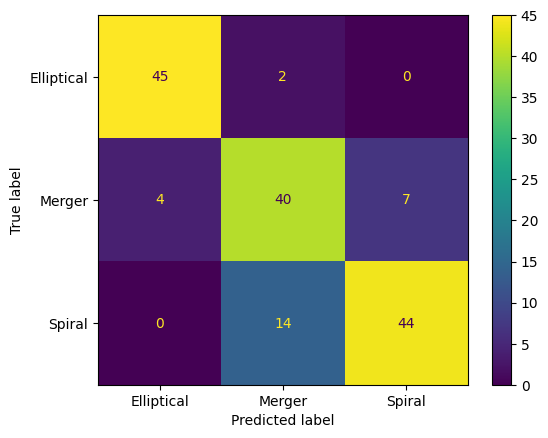

In [13]:
#Making the confusion matrix
import sklearn.metrics as metrics
matrix = metrics.confusion_matrix(actual_class, predicted_class)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ['Elliptical', 'Merger', 'Spiral'])
cm_display.plot()
plt.show()

In [38]:
acc = metrics.accuracy_score(actual_class, predicted_class)
print('The decision tree classifier is', round(acc, 2),"% accurate")

The decision tree classifier is 0.84 % accurate


In [22]:
#Getting the precision of the model
pre = (True_ellip+True_merger+True_spiral)/(merger_false_elliptical+spiral_false_elliptical+elliptical_false_merger+elliptical_false_spiral+elliptical_false_spiral+merger_false_spiral+True_ellip+True_merger+True_spiral)
print('The precision of the model is', round(pre, 3))

The precision of the model is 0.908


*References*\
[1] Decision tree Clasifier https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html\
[2] Confusion Matrix https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html